# Loading Modules

In [1]:
import gcsfs #module for google cloud connection
import os
import allel
import zarr
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns
import h5py

Phase1 and Phase2 are different, either the outgroup alleles are different from phase2. They're based on phase 1 pass and REF and ALT alleles are different on the 2 phases. 
So the 1st step is find the positions shared from phase1 and phase2. After do that, apply these positions to phase2. Then map outgroup chromosomes.

### Loading datasets of phase1 and phase2

In [2]:
gcs_orig = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache')
gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token=gcs_orig.session.credentials)

In [3]:
#phase2path = os.path.join("ag1000g-release", "phase2.AR1", "variation", "main", "zarr", "pass", "ag1000g.phase2.ar1.pass")
phase2path = os.path.join("ag1000g-release", "phase2.AR1", "variation", "main", "zarr", "biallelic", "ag1000g.phase2.ar1.pass.biallelic")

In [4]:
gcsmap2 = gcsfs.mapping.GCSMap(phase2path, gcs=gcs)

In [5]:
calldata_phase2= zarr.Group(gcsmap2, read_only=True)

In [6]:
phase1path = os.path.join("ag1000g-release", "phase1.AR3", "variation", "main", "zarr", "ag1000g.phase1.ar3.pass")

In [7]:
gcsmap1 = gcsfs.mapping.GCSMap(phase1path, gcs=gcs)

In [8]:
calldata_phase1= zarr.Group(gcsmap1, read_only=True)

-----------------------------------------------------

### Loading positions

In [9]:
pos_phase1 = allel.SortedIndex(calldata_phase1["2L"]["variants/POS"][:])
pos_phase1

0,1,2,3,4,...,10377275,10377276,10377277,10377278,10377279
44688,44691,44732,44736,44756,...,49356424,49356425,49356426,49356429,49356435


In [10]:
pos_phase2 = allel.SortedIndex(calldata_phase2["2L"]["variants/POS"])
pos_phase2

0,1,2,3,4,...,8906418,8906419,8906420,8906421,8906422
25050,51212,51214,51226,51245,...,49356421,49356424,49356425,49356426,49356429


Now I have to take only phase1 positions in phase2

In [11]:
loc1, loc2 = pos_phase2.locate_intersection(pos_phase1)
loc1, loc2

(array([False,  True,  True, ...,  True,  True,  True]),
 array([False, False, False, ...,  True,  True, False]))

In [12]:
pos_p2_sel = pos_phase2[loc1]
pos_p2_sel

0,1,2,3,4,...,7635919,7635920,7635921,7635922,7635923
51212,51214,51226,51245,51251,...,49356421,49356424,49356425,49356426,49356429


In [13]:
pos_p1_sel = pos_phase1[loc2]
pos_p1_sel

0,1,2,3,4,...,7635919,7635920,7635921,7635922,7635923
51212,51214,51226,51245,51251,...,49356421,49356424,49356425,49356426,49356429


------------------------------

In [14]:
variants_phase1 = allel.VariantChunkedTable(calldata_phase1["2L"]["variants"], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'numalt'],
                                     index='POS')
variants_phase1

<VariantChunkedTable shape=(10377280,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4'), ('numalt', '<i4')]
   nbytes=237.5M cbytes=-7 cratio=-35579245.7
   values=zarr.hierarchy.Group>

In [15]:
variants_phase1_filt = variants_phase1.compress(loc2)
variants_phase1_filt

<VariantChunkedTable shape=(7635924,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4'), ('numalt', '<i4')]
   nbytes=174.8M cbytes=77.7M cratio=2.2
   values=allel.chunked.storage_zarr.ZarrTable>

In [16]:
phase1_ref = variants_phase1_filt["REF"][:]
phase1_ref, phase1_ref.shape

(array([b'T', b'G', b'A', ..., b'G', b'G', b'A'], dtype='|S1'), (7635924,))

In [17]:
phase1_alt = variants_phase1_filt["ALT"][:]
phase1_alt, phase1_ref.shape

(array([[b'A', b'', b''],
        [b'C', b'', b''],
        [b'G', b'', b''],
        ...,
        [b'T', b'', b''],
        [b'T', b'', b''],
        [b'G', b'', b'']], dtype='|S1'), (7635924,))

------------------------------------------------

In [18]:
variants_phase2 = allel.VariantChunkedTable(calldata_phase2["2L"]["variants"], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'numalt'],
                                     index='POS')
variants_phase2

<VariantChunkedTable shape=(8906423,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1'), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4'), ('numalt', '<i4')]
   nbytes=186.9M cbytes=-7 cratio=-27991615.1
   values=zarr.hierarchy.Group>

In [19]:
variants_phase2_filt = variants_phase2.compress(loc1)
variants_phase2_filt

<VariantChunkedTable shape=(7635924,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1'), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4'), ('numalt', '<i4')]
   nbytes=160.2M cbytes=74.2M cratio=2.2
   values=allel.chunked.storage_zarr.ZarrTable>

In [20]:
phase2_ref = variants_phase2_filt["REF"][:]
phase2_ref, phase2_ref.shape

(array([b'T', b'G', b'A', ..., b'G', b'G', b'A'], dtype='|S1'), (7635924,))

In [21]:
phase2_alt = variants_phase2_filt["ALT"][:]
phase2_alt, phase2_ref.shape

(array([b'A', b'C', b'G', ..., b'T', b'T', b'G'], dtype='|S1'), (7635924,))

In [22]:
phase2refalt = np.column_stack([phase2_ref, phase2_alt])
phase2refalt, phase2refalt.shape

(array([[b'T', b'A'],
        [b'G', b'C'],
        [b'A', b'G'],
        ...,
        [b'G', b'T'],
        [b'G', b'T'],
        [b'A', b'G']], dtype='|S1'), (7635924, 2))

In [23]:
mapping = allel.create_allele_mapping(phase1_ref, phase1_alt, phase2refalt)
mapping

array([[ 0,  1, -1, -1],
       [ 0,  1, -1, -1],
       [ 0,  1, -1, -1],
       ...,
       [ 0,  1, -1, -1],
       [ 0,  1, -1, -1],
       [ 0,  1, -1, -1]], dtype=int8)

this will case an error
you can combine a [N, 1] + [N, 3]
but not [N,] + [N, 3]
phase2refalt = np.hstack([phase2_ref, phase2_alt])

assert phase2refalt.shape[1] == 4

In [24]:
mapping = allel.create_allele_mapping(phase1_ref, phase1_alt, phase2refalt)
mapping

array([[ 0,  1, -1, -1],
       [ 0,  1, -1, -1],
       [ 0,  1, -1, -1],
       ...,
       [ 0,  1, -1, -1],
       [ 0,  1, -1, -1],
       [ 0,  1, -1, -1]], dtype=int8)

------------------------------

### Selecting same SNPs from christi dataset

In [25]:
calldata_out= h5py.File('/gcs/phase1.AR3/extras/outgroup_allele_counts.h5', mode='r')
calldata_out

<HDF5 file "outgroup_allele_counts.h5" (mode r)>

In [26]:
calldata_chr = calldata_out['2L']['chri']
calldata_chr[:], calldata_chr.shape

(array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=int32), (10377280, 4))

In [27]:
loc2.shape, calldata_chr.shape

((10377280,), (10377280, 4))

In [28]:
loc2

array([False, False, False, ...,  True,  True, False])

In [29]:
ac_snp_chri = allel.AlleleCountsArray(calldata_chr)
ac_snp_chri

<AlleleCountsArray shape=(10377280, 4) dtype=int32>
0 0 0 0
0 0 0 0
0 0 0 0
...
0 0 0 0
0 0 0 0
0 0 0 0

In [30]:
ac_snp_chri = ac_snp_chri.compress(loc2)
ac_snp_chri

<AlleleCountsArray shape=(7635924, 4) dtype=int32>
0 0 0 0
0 0 0 0
0 0 0 0
...
0 0 0 0
0 0 0 0
0 0 0 0

In [31]:
mapping.shape, ac_snp_chri.shape

((7635924, 4), (7635924, 4))

In [32]:
chri_allele_count = ac_snp_chri.map_alleles(mapping)
chri_allele_count

<AlleleCountsArray shape=(7635924, 2) dtype=int32>
0 0
0 0
0 0
...
0 0
0 0
0 0

----------------------------

### Phase2 allele count subset

In [35]:
metadata = pd.read_csv("samples.meta.txt", sep="\t")
pop_select = metadata.population.isin({'BFgam', 'GAgam', 'AOcol'}).values
pop_subset = metadata[pop_select]

In [36]:
genotypes_phase2_call = calldata_phase2["2L"]["calldata/GT"]
genotypes_phase2 = allel.GenotypeChunkedArray(genotypes_phase2_call)

In [37]:
genotypes_phase2

<GenotypeChunkedArray shape=(8906423, 1142, 2) dtype=int8 chunks=(524288, 61, 2)
   nbytes=18.9G cbytes=-1 cratio=-20342270132.0
   compression=blosc compression_opts={'cname': 'zstd', 'clevel': 1, 'shuffle': -1, 'blocksize': 0}
   values=zarr.core.Array>

In [39]:
genotypes_phase2.shape, loc1.shape

((8906423, 1142, 2), (8906423,))

In [40]:
geno_p2_subset = genotypes_phase2.subset(sel0=loc1, sel1=pop_select)
geno_p2_subset

<GenotypeChunkedArray shape=(7635924, 239, 2) dtype=int8 chunks=(7457, 239, 2)
   nbytes=3.4G cbytes=152.1M cratio=22.9
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [41]:
#count alleles
grp = pop_subset.groupby("population")
grp_indices = grp.indices
ac_subpops = geno_p2_subset.count_alleles_subpops(grp_indices)

In [42]:
ac_subpops

<AlleleCountsChunkedTable shape=(7635924,) dtype=[('AOcol', '<i4', (2,)), ('BFgam', '<i4', (2,)), ('GAgam', '<i4', (2,))]
   nbytes=174.8M cbytes=16.7M cratio=10.5
   values=allel.chunked.storage_zarr.ZarrTable>

----------------------------------------------------------

### Perform ABBA BABA Test

In [43]:
chrom = '2L'

In [44]:
#perform abba baba test
y = allel.average_patterson_d(ac_subpops['BFgam'], ac_subpops['GAgam'], ac_subpops['AOcol'], chri_allele_count, 10000)

In [45]:
# compute windows with equal numbers of SNPs
windows = allel.moving_statistic(pos_p2_sel, statistic=lambda v: [v[0], v[-1]], size=10000)
x = np.asarray(windows).mean(axis=1) 

(0, 49356429)

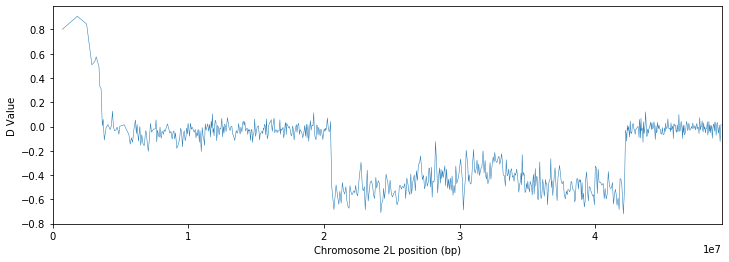

In [46]:
# Plot the test
fig, ax = pyplot.subplots(figsize=(12, 4))
#sns.despine(ax=ax, offset=10)
ax.plot(x, y[3], lw=.5)
ax.set_ylabel("D Value")
ax.set_xlabel('Chromosome %s position (bp)' %chrom)
ax.set_xlim(0, pos_p2_sel.max())

----------------------------------------------------------------

#### Sandbox

In [81]:
variants_phase1 = allel.VariantChunkedTable(calldata_phase1["2L"]["variants"], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'numalt'],
                                     index='POS')
variants_phase1

<VariantChunkedTable shape=(10377280,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4'), ('numalt', '<i4')]
   nbytes=237.5M cbytes=-7 cratio=-35579245.7
   values=zarr.hierarchy.Group>

In [9]:
calldata_phase2= zarr.Group(gcsmap2, read_only=True)

In [10]:
variants_phase2 = allel.VariantChunkedTable(calldata_phase2["2L"]["variants"], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'numalt'],
                                     index='POS')
variants_phase2

<VariantChunkedTable shape=(8906423,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1'), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4'), ('numalt', '<i4')]
   nbytes=186.9M cbytes=-7 cratio=-27991615.1
   values=zarr.hierarchy.Group>

In [60]:
calldata_out= h5py.File('/gcs/phase1.AR3/extras/outgroup_alleles.h5', mode='r')
calldata_out

<HDF5 file "outgroup_alleles.h5" (mode r)>

In [61]:
calldata_out.keys()

<KeysViewHDF5 ['2L', '2R', '3L', '3R', 'X']>

In [62]:
calldata_out['2L'].keys()

<KeysViewHDF5 ['arab', 'chri', 'epir', 'mela', 'meru', 'quad']>

In [63]:
calldata_out['2L']['chri'][1000_000:1000_010]numpy.isnan(myarray).any()

array([b'C', b'G', b'C', b'C', b'C', b'C', b'G', b'C', b'C', b'T'],
      dtype='|S1')

In [64]:
calldata_chr = calldata_out['2L']['chri']
calldata_chr[:], calldata_chr.shape

(array([b'.', b'.', b'.', ..., b'.', b'.', b'.'], dtype='|S1'), (10377280,))

In [65]:
calldata_out_count= h5py.File('/gcs/phase1.AR3/extras/outgroup_allele_counts.h5', mode='r')
calldata_out_count

<HDF5 file "outgroup_allele_counts.h5" (mode r)>

In [66]:
calldata_out_count.keys()

<KeysViewHDF5 ['2L', '2R', '3L', '3R', 'X']>

In [67]:
calldata_out_count['2L'].keys()

<KeysViewHDF5 ['arab', 'chri', 'epir', 'mela', 'meru', 'quad']>

In [68]:
calldata_out_count['2L']['chri'][1000_000:1000_010]

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0]], dtype=int32)

In [69]:
calldata_chr_count = calldata_out_count['2L']['chri']
calldata_chr_count[:], calldata_chr_count.shape

(array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=int32), (10377280, 4))

In [26]:
b = np.asarray(calldata_chr)

In [41]:
asd = b.tolist()

In [45]:
a = list(filter(lambda x: x!= b'.', asd))

In [47]:
len(a)

7793733

In [94]:
phase2_ref = calldata_phase2["2L"]["variants"]["REF"][:]
phase2_ref, phase2_ref.shape

(array([b'G', b'T', b'G', ..., b'G', b'G', b'A'], dtype='|S1'), (8906423,))

In [95]:
phase2_alt = calldata_phase2["2L"]["variants"]["ALT"][:]
phase2_alt, phase2_alt.shape

(array([b'T', b'A', b'C', ..., b'T', b'T', b'G'], dtype='|S1'), (8906423,))

In [96]:
allel.create_allele_mapping(phase2_ref, phase2_alt, calldata_chr)

ValueError: arrays do not have matching length for dimension 0